In [1]:
from utils import (LastOnlyRegressorChain, plot_error_over_horizon, plot_most_influential_chained_prediction)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.multioutput import RegressorChain, MultiOutputRegressor
from dataclasses import dataclass
from typing import List, Union
from tueplots.constants.color import rgb

In [2]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.close('all')
plt.style.use('default')

# 1. Data Loading

In [3]:
supply = pd.read_csv('data/Realised_Supply_Germany.csv', index_col=0, sep=';')
supply = supply[['Solar Power [MW]']]
supply.index = pd.to_datetime(supply.index, format='%d.%m.%y %H:%M')
supply['Solar Power [MW]'] = supply['Solar Power [MW]'].str.replace('.', '', regex=False)
supply['Solar Power [MW]'] = supply['Solar Power [MW]'].str.replace(',', '.', regex=False)
supply['Solar Power [MW]'] = pd.to_numeric(supply['Solar Power [MW]'], errors='raise')


In [4]:
weather = pd.read_csv('data/Weather_Data_Germany.csv', sep=',', decimal='.')
weather.time = pd.to_datetime(weather.time, format='%Y-%m-%d %H:%M:%S')
weather.set_index('time', inplace=True)
weather = weather.drop(columns=['forecast_origin'])

In [5]:
weather2022 = pd.read_csv('data/Weather_Data_Germany_2022.csv', sep=',', decimal='.')
weather2022.time = pd.to_datetime(weather2022.time, format='%Y-%m-%d %H:%M:%S')
weather2022.set_index('time', inplace=True)
weather2022 = weather2022.drop(columns=['forecast_origin'])

In [6]:
weather = pd.concat([weather,weather2022])
print(f"Start date: {weather.index.min()}")
print(f"End date: {weather.index.max()}")

Start date: 2019-01-01 00:00:00
End date: 2022-12-31 23:00:00


# 2 Data Preprocessing

## 2.1 Reduce time precision to match weather

In [7]:
# Match time precision by summing up to the hour
supply = supply.resample('H').sum()

## 2.2 Aggregate over weather stations
Since the Supply Data is Germany wide, we will average the weather from different locations as XGBoost needs tabular data.

In [8]:
# Aggregate weather data from different weather stations
weather = weather.drop(columns=['z', 'latitude', 'longitude'])
weather = weather.groupby(weather.index).mean()

## 2.3 Normalize values
XGBoost is sensitive to unnormalized values so we set the mean 0 and the std 1 using the scipy standard scaler

In [9]:
scaler = StandardScaler()
weather_scaled = scaler.fit_transform(weather)
weather_scaled = pd.DataFrame(weather_scaled, index=weather.index, columns=weather.columns)

## 2.4 Create Time Series features
We could provide the date to the model but is often more effective to provide additional information and split the info into distinct features.  
We will add the most common features and later check which ones we actually need.

In [10]:
# Add time features
weather_scaled['hour'] = weather_scaled.index.hour
weather_scaled['dayofweek'] = weather_scaled.index.dayofweek
weather_scaled['month'] = weather_scaled.index.month
weather_scaled['dayofyear'] = weather_scaled.index.dayofyear
weather_scaled['year'] = weather_scaled.index.year
weather_scaled['weekofyear'] = weather_scaled.index.isocalendar().week
weather_scaled['dayofmonth'] = weather_scaled.index.day

## 2.5 Train/Test Split
Splitting in time series data should always be in order and contain a whole season, so we are using 2022 as the test set.

In [11]:
# Train-test split
cutoff_date = pd.to_datetime('2022-01-01')

X_train = weather_scaled[weather_scaled.index < cutoff_date]
X_test = weather_scaled[weather_scaled.index >= cutoff_date]
y_train = supply[supply.index < cutoff_date]
y_test = supply[supply.index >= cutoff_date]
# Write the data to CSV files
X_train.to_csv('tmp/X_train.csv', sep=';', decimal=',')
X_test.to_csv('tmp/X_test.csv', sep=';', decimal=',')
y_train.to_csv('tmp/y_train.csv', sep=';', decimal=',')
y_test.to_csv('tmp/y_test.csv', sep=';', decimal=',')

# 3 Feature Selection
There are still quite a lot of features in the weather data. We can use Lasso Regression to find the most important ones.

In [12]:
# Load Data
X_train = pd.read_csv('tmp/X_train.csv', sep=';', decimal=',', index_col=0)
X_test = pd.read_csv('tmp/X_test.csv', sep=';', decimal=',', index_col=0)
y_train = pd.read_csv('tmp/y_train.csv', sep=';', decimal=',', index_col=0)
y_test = pd.read_csv('tmp/y_test.csv', sep=';', decimal=',', index_col=0)

In [13]:
lasso_cv = LassoCV(cv= 5, random_state=1312).fit(X_train, y_train.squeeze())
best_alpha = lasso_cv.alpha_

lasso = Lasso(alpha=best_alpha, random_state=1312)
_ = lasso.fit(X_train, y_train.squeeze())

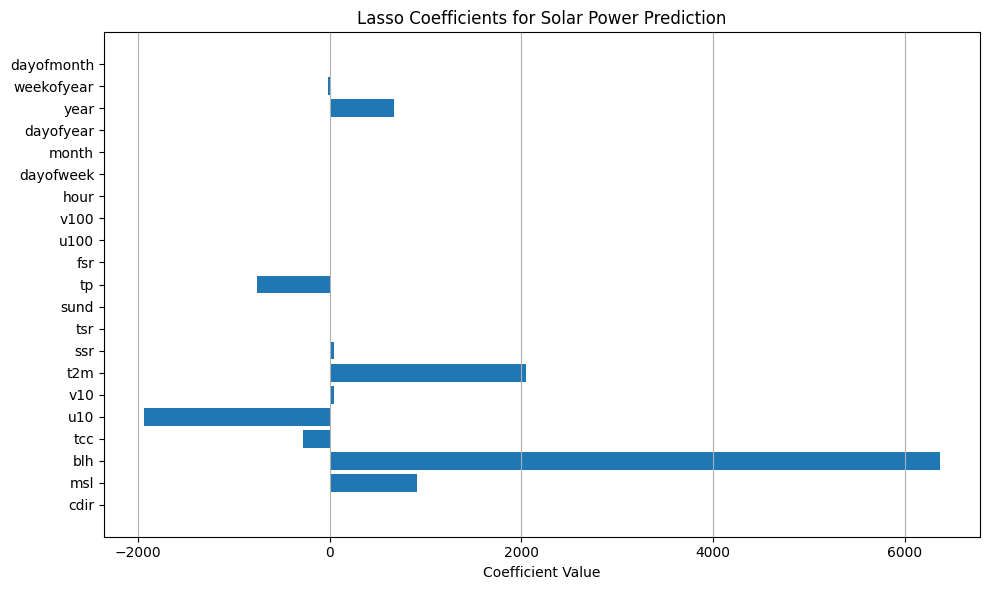

In [14]:
# Plot coefficients
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, lasso.coef_)
plt.xlabel('Coefficient Value')
plt.title('Lasso Coefficients for Solar Power Prediction')
plt.grid(axis='x')
plt.tight_layout()

In [15]:
# Drop Features with zero coefficients
X_train_selected = X_train.loc[:, lasso.coef_ != 0]
X_test_selected = X_test.loc[:, lasso.coef_ != 0]
print(f"Number of features after Lasso: {X_train_selected.shape[1]}")

Number of features after Lasso: 13


In [16]:
# Save the selected features
X_train_selected.to_csv('tmp/X_train_selected.csv', sep=';', decimal=',')
X_test_selected.to_csv('tmp/X_test_selected.csv', sep=';', decimal=',')

# 4. Model Training

In [17]:
# Load data
X_train_selected = pd.read_csv('tmp/X_train_selected.csv', sep=';', decimal=',', index_col=0)
X_test_selected = pd.read_csv('tmp/X_test_selected.csv', sep=';', decimal=',', index_col=0)
X_train = pd.read_csv('tmp/X_train.csv', sep=';', decimal=',', index_col=0)
X_test = pd.read_csv('tmp/X_test.csv', sep=';', decimal=',', index_col=0)
y_train = pd.read_csv('tmp/y_train.csv', sep=';', decimal=',', index_col=0)
y_test = pd.read_csv('tmp/y_test.csv', sep=';', decimal=',', index_col=0)

In [18]:
# Set up data structure for evaluation later

@dataclass
class ModelEvaluation:
    model_name: str
    model: object
    horizon: int
    y_pred: np.ndarray
    R2_score: float
    RMSE: Union[float, List[float]]
    MAE: Union[float, List[float]]

evaluations = []


## 4.1 Prediction
Lets start with the simplest model and task. We train to take a datapoint of weather features $\mathbf X$ and predict the corresponding Solar Supply $ y$ both at time point $t$.

### 4.1.1 Lasso
We start with a very simple baseline model and for that we use Lasso.


In [19]:
# Lasso Prediction
lasso_cv = LassoCV(cv= 5, random_state=1312).fit(X_train_selected, y_train.squeeze())
best_alpha = lasso_cv.alpha_

lasso = Lasso(alpha=best_alpha, max_iter=1000, random_state=1312)
_ = lasso.fit(X_train_selected, y_train.squeeze())

y_pred_lasso = lasso.predict(X_test_selected)
r2_score_lasso = lasso.score(X_test_selected, y_test.squeeze())

In [20]:
lasso_eval = ModelEvaluation(
    model_name='Lasso',
    model=lasso,
    horizon=1,
    y_pred=y_pred_lasso,
    R2_score=r2_score_lasso,
    RMSE=mean_squared_error(y_test.squeeze(), y_pred_lasso, squared=False),
    MAE=mean_absolute_error(y_test.squeeze(), y_pred_lasso)
)
evaluations.append(lasso_eval)
print(f"{lasso_eval.model_name}: R2: {lasso_eval.R2_score}, RMSE: {lasso_eval.RMSE}, MAE: {lasso_eval.MAE}")

Lasso: R2: 0.7847323675240458, RMSE: 4429.891845241874, MAE: 3389.2582629639046


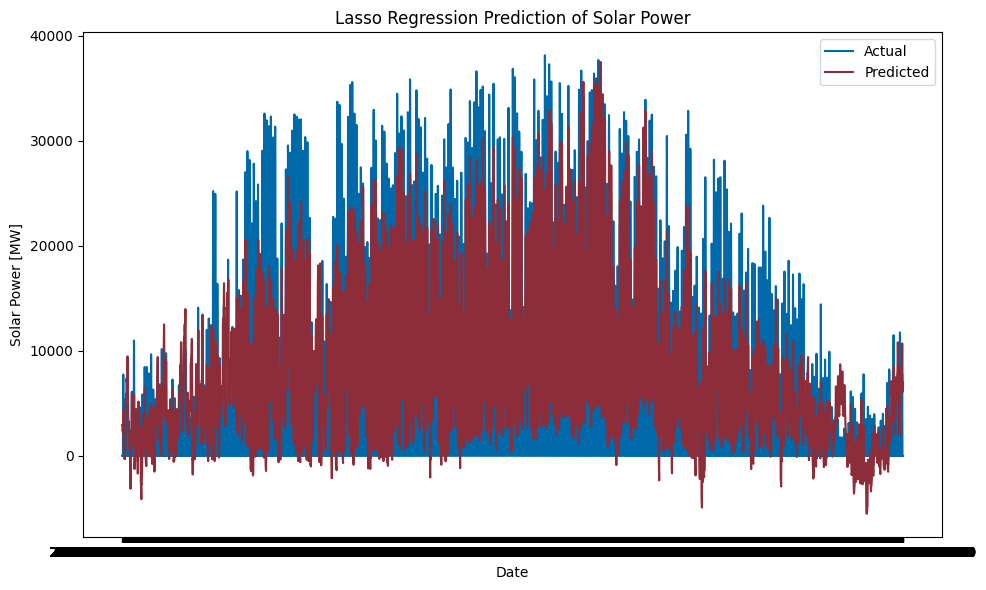

In [21]:
# Plot Lasso Prediction
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color=rgb.tue_blue)
plt.plot(y_test.index, y_pred_lasso, label='Predicted', color=rgb.tue_red)
plt.xlabel('Date')
plt.ylabel('Solar Power [MW]')
plt.title('Lasso Regression Prediction of Solar Power')
plt.legend()
plt.tight_layout()
plt.show()

### 4.1.2 XGBoost
Now we can start with the actual model we want to train.

In [22]:
# XGBoost Prediction
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    random_state=1312,
)

xgb_model.fit(X_train_selected, y_train.squeeze())

xgb_pred = xgb_model.predict(X_test_selected)
r2_score_xgb = xgb_model.score(X_test_selected, y_test.squeeze())

In [23]:
# Feature selection check
xgb_model_naive = xgb.XGBRegressor(
    n_estimators=1000,
    random_state=1312,
)
xgb_model_naive.fit(X_train, y_train.squeeze())
xgb_pred_naive = xgb_model_naive.predict(X_test)
r2_score_xgb_naive = xgb_model_naive.score(X_test, y_test.squeeze())

In [24]:
xgb_eval = ModelEvaluation(
    model_name='XGBoost',
    model=xgb_model,
    horizon=1,
    y_pred=xgb_pred,
    R2_score=r2_score_xgb,
    RMSE=mean_squared_error(y_test.squeeze(), xgb_pred, squared=False),
    MAE=mean_absolute_error(y_test.squeeze(), xgb_pred)
)
xgb_eval_naive = ModelEvaluation(
    model_name='XGBoost Naive',
    model=xgb_model_naive,
    horizon=1,
    y_pred=xgb_pred_naive,
    R2_score=r2_score_xgb_naive,
    RMSE=mean_squared_error(y_test.squeeze(), xgb_pred_naive, squared=False),
    MAE=mean_absolute_error(y_test.squeeze(), xgb_pred_naive)
)
evaluations.append(xgb_eval)
evaluations.append(xgb_eval_naive)
print(f"{xgb_eval.model_name}: R2: {xgb_eval.R2_score}, RMSE: {xgb_eval.RMSE}, MAE: {xgb_eval.MAE}")
print(f"{xgb_eval_naive.model_name}: R2: {xgb_eval_naive.R2_score}, RMSE: {xgb_eval_naive.RMSE}, MAE: {xgb_eval_naive.MAE}")

XGBoost: R2: 0.9712215521555476, RMSE: 1619.710655562959, MAE: 949.0809680836198
XGBoost Naive: R2: 0.9740071216935442, RMSE: 1539.3271972932725, MAE: 910.1493204327858


We can see no notable difference in any evaluation criteria so we will use only the selected features as it is faster. (This will matter later)

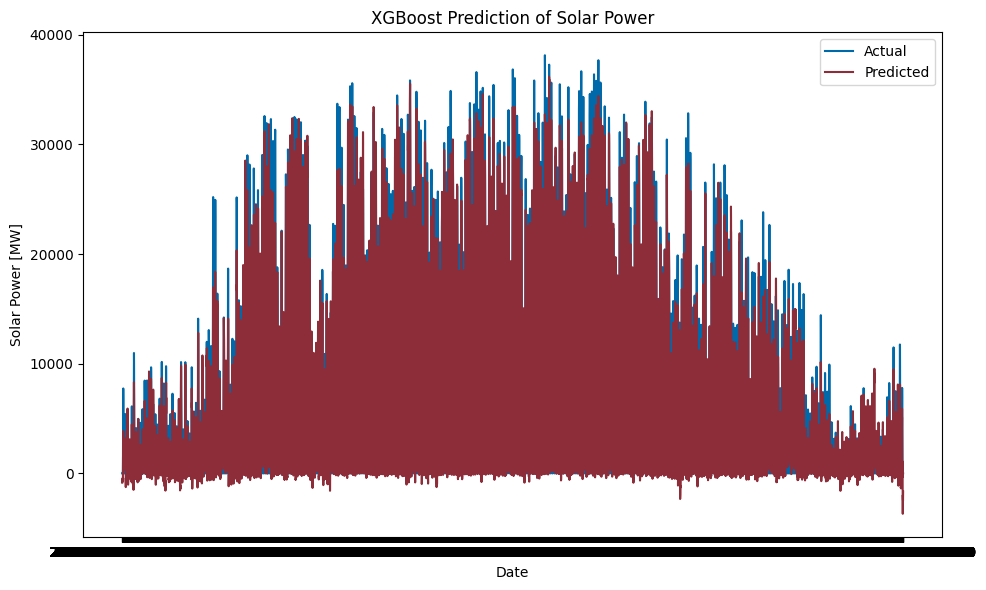

In [25]:
# Plot XGBoost Prediction
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color=rgb.tue_blue)
plt.plot(y_test.index, xgb_pred, label='Predicted', color=rgb.tue_red)
plt.xlabel('Date')
plt.ylabel('Solar Power [MW]')
plt.title('XGBoost Prediction of Solar Power')
plt.legend()
plt.tight_layout()
plt.show()

## 4.2 Forecasting
Now we increase our horizon to the 24 hours we actually want.  
With XGBoost, we do this by training a regressor for every step ahead. So we end up with 24 regressors each specialized to predict s hours ahead of t.
We start by training these regressors as parallel predictors that are unaware of each other.

### 4.2.1 Parallel XGBoost

In [26]:
# Transform the target y to include the next h hours
horizon = 24
y_train_horizon = y_train.copy()
y_test_horizon = y_test.copy()
for i in range(1, horizon):
    y_train_horizon[f"t+{i}"] = y_train.shift(-i)
    y_test_horizon[f"t+{i}"] = y_test.shift(-i)
    
y_train_horizon = y_train_horizon.dropna()
y_test_horizon = y_test_horizon.dropna()
X_train_horizon = X_train_selected.loc[y_train_horizon.index]
X_test_horizon = X_test_selected.loc[y_test_horizon.index]

In [27]:
# Train a MultiOutput Regressor with XGBoost
xgb_parallel = MultiOutputRegressor(
    xgb.XGBRegressor(
        n_estimators=1000,
        random_state=1312,
    )
)
xgb_parallel.fit(X_train_horizon, y_train_horizon)
xgb_pred_parallel = xgb_parallel.predict(X_test_horizon)
r2_score_xgb_parallel = xgb_parallel.score(X_test_horizon, y_test_horizon)

In [28]:
xgb_parallel_eval = ModelEvaluation(
    model_name='Parallel',
    model=xgb_parallel,
    horizon=horizon,
    y_pred=pd.DataFrame(xgb_pred_parallel, index=y_test_horizon.index),
    R2_score=r2_score_xgb_parallel,
    RMSE=[mean_squared_error(y_test_horizon.iloc[:, i], xgb_pred_parallel[:, i], squared=False) for i in range(horizon)],
    MAE=[mean_absolute_error(y_test_horizon.iloc[:, i], xgb_pred_parallel[:, i]) for i in range(horizon)]
)
evaluations.append(xgb_parallel_eval)

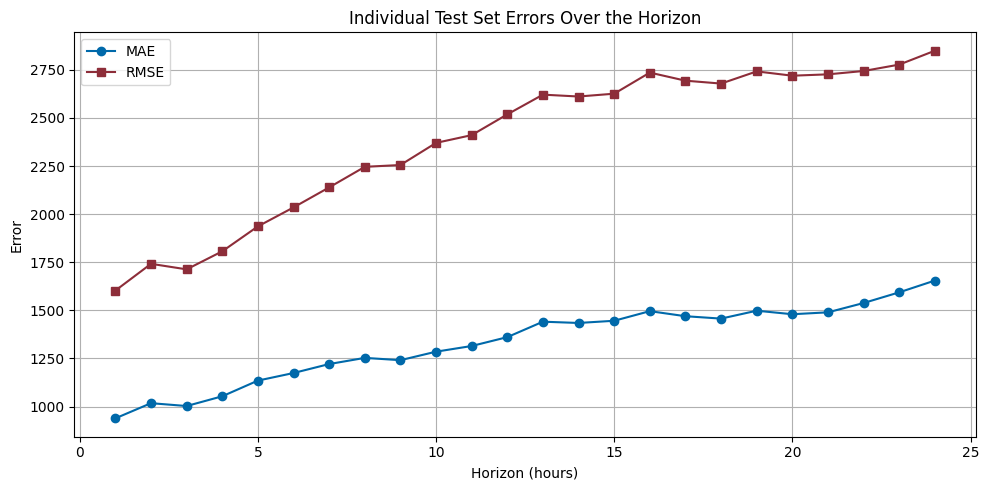

In [29]:
# Plot XGBoost Parallel Prediction
plot_error_over_horizon(y_test_horizon,xgb_pred_parallel, horizon=horizon)

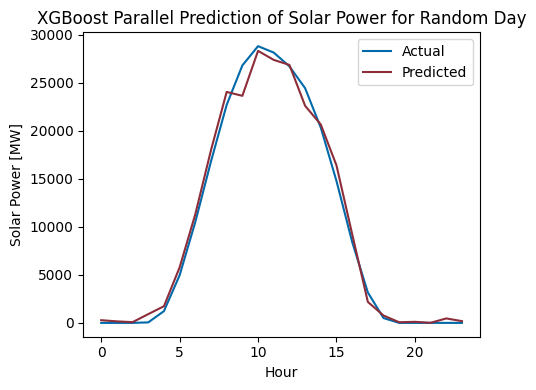

In [30]:
# Plot random days from the XGBoost Parallel Prediction
fig = plt.figure(figsize=(5, 4))
rand_idx = np.random.randint(0, len(y_test_horizon.index))
row = y_test_horizon.iloc[rand_idx]
plt.plot(row.values, label='Actual', color=rgb.tue_blue)
plt.plot(xgb_pred_parallel[rand_idx, :], label='Predicted', color=rgb.tue_red)
plt.xlabel('Hour')
plt.ylabel('Solar Power [MW]')
plt.title('XGBoost Parallel Prediction of Solar Power for Random Day')
plt.legend()
plt.tight_layout()
plt.show()

### 4.2.2 Chained XGBoost
Now we can make the model autoregressive by giving regressor $s$ all previous predictions from $[0,s-1]$

In [31]:
# Train a RegressorChain with XGBoost
xgb_chained = RegressorChain(
    xgb.XGBRegressor(
        n_estimators=1000,
        random_state=1312,
    )
)
xgb_chained.fit(X_train_horizon, y_train_horizon)
xgb_pred_chained = xgb_chained.predict(X_test_horizon)
r2_score_xgb_chained = xgb_chained.score(X_test_horizon, y_test_horizon)

In [32]:
xgb_chained_eval = ModelEvaluation(
    model_name='Chained',
    model=xgb_chained,
    horizon=horizon,
    y_pred=pd.DataFrame(xgb_pred_chained, index=y_test_horizon.index),
    R2_score=r2_score_xgb_chained,
    RMSE=[mean_squared_error(y_test_horizon.iloc[:, i], xgb_pred_chained[:, i], squared=False) for i in range(horizon)],
    MAE=[mean_absolute_error(y_test_horizon.iloc[:, i], xgb_pred_chained[:, i]) for i in range(horizon)]
)
evaluations.append(xgb_chained_eval)

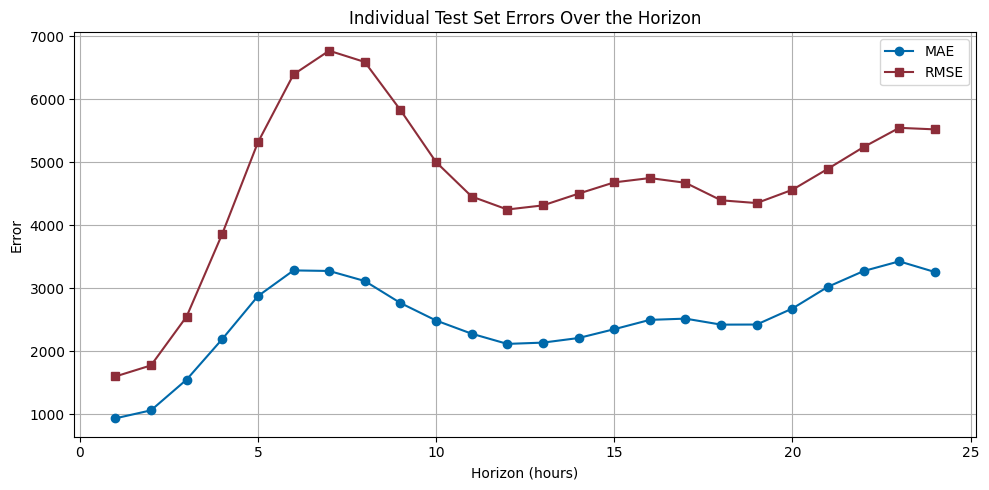

In [33]:
# Plot XGBoost Parallel Prediction
plot_error_over_horizon(y_test_horizon,xgb_pred_chained, horizon=horizon)

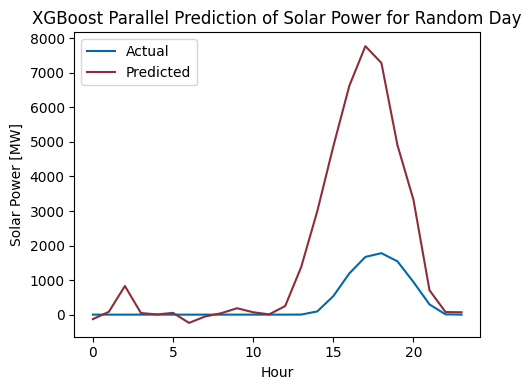

In [34]:
# Plot random days from the XGBoost Parallel Prediction
fig = plt.figure(figsize=(5, 4))
rand_idx = np.random.randint(0, len(y_test_horizon.index))
row = y_test_horizon.iloc[rand_idx]
plt.plot(row.values, label='Actual', color=rgb.tue_blue)
plt.plot(xgb_pred_chained[rand_idx, :], label='Predicted', color=rgb.tue_red)
plt.xlabel('Hour')
plt.ylabel('Solar Power [MW]')
plt.title('XGBoost Parallel Prediction of Solar Power for Random Day')
plt.legend()
plt.tight_layout()
plt.show()

Does the model even need all previous predictions? Lets look at the most important one at every time step. XGBoost gives us feature importance that show us exactly that (and more)

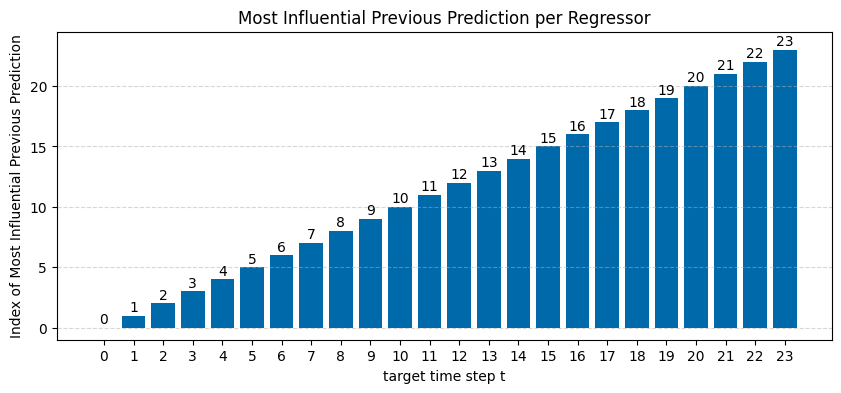

In [35]:
# Feature importance for the chained model
importances = [list(estimator.get_booster().get_score().values()) for estimator in xgb_chained.estimators_]
plot_most_influential_chained_prediction(importances, 12)

At every time step $t$, the most influential previous result is $t-1$ so lets discard the rest

### 4.2.3 Last Only Chained XGBoost

In [36]:
# Last Only Regressor Chain
last_only_chain = LastOnlyRegressorChain(
    xgb.XGBRegressor(
        n_estimators=1000,
        random_state=1312,
    )
)
last_only_chain.fit(X_train_horizon.to_numpy(), y_train_horizon.to_numpy())
xgb_pred_last_only = last_only_chain.predict(X_test_horizon.to_numpy())
r2_score_xgb_last_only = last_only_chain.score(X_test_horizon.to_numpy(), y_test_horizon)

In [37]:
xgb_last_only_eval = ModelEvaluation(
    model_name='Chained Last Only',
    model=last_only_chain,
    horizon=horizon,
    y_pred=pd.DataFrame(xgb_pred_last_only, index=y_test_horizon.index),
    R2_score=r2_score_xgb_last_only,
    RMSE=[mean_squared_error(y_test_horizon.iloc[:, i], xgb_pred_last_only[:, i], squared=False) for i in range(horizon)],
    MAE=[mean_absolute_error(y_test_horizon.iloc[:, i], xgb_pred_last_only[:, i]) for i in range(horizon)]
)
evaluations.append(xgb_last_only_eval)

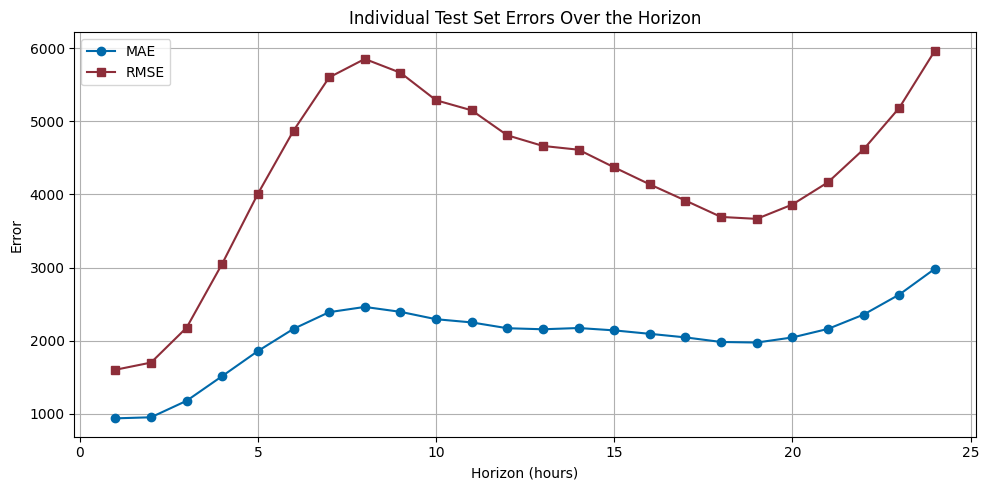

In [38]:
# Plot XGBoost Parallel Prediction
plot_error_over_horizon(y_test_horizon,xgb_pred_last_only, horizon=horizon)

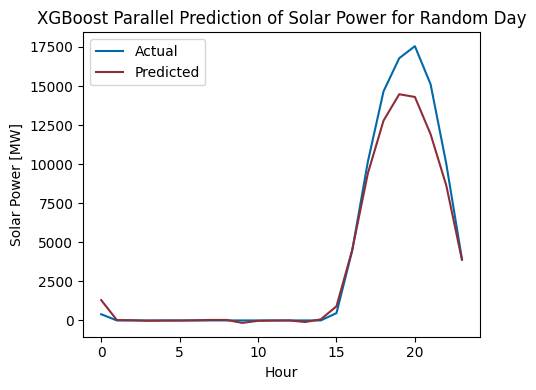

In [39]:
# Plot random days from the XGBoost Parallel Prediction
fig = plt.figure(figsize=(5, 4))
rand_idx = np.random.randint(0, len(y_test_horizon.index))
row = y_test_horizon.iloc[rand_idx]
plt.plot(row.values, label='Actual', color=rgb.tue_blue)
plt.plot(xgb_pred_last_only[rand_idx, :], label='Predicted', color=rgb.tue_red)
plt.xlabel('Hour')
plt.ylabel('Solar Power [MW]')
plt.title('XGBoost Parallel Prediction of Solar Power for Random Day')
plt.legend()
plt.tight_layout()
plt.show()

### 4.2.4 Lagged Features
Ok including the previous prediction result resulted in some benefit but we can also include the previous time steps of X.  
This is common practice in dealing with time series. If we want to know how many time steps back we need to go, we can look at the partial auto correlation.

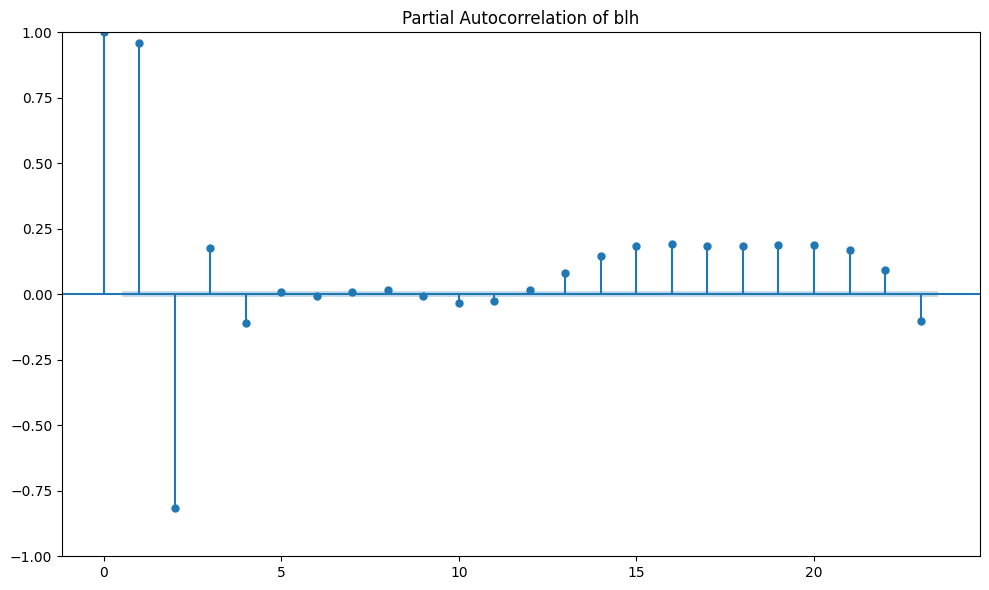

In [40]:
# Partial autocorrelation plot for most important feature
from statsmodels.graphics.tsaplots import plot_pacf, pacf
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(X_train_horizon["blh"], lags=horizon-1, ax=ax)
ax.set_title('Partial Autocorrelation of blh')
plt.tight_layout()
plt.show()

For BLH we can see that the PACF for lags 1 and 2 are much more relevant than the others. We can do this for every feature and include those lags.

In [41]:
# Get lags over threshhold for every feature using PACF
lags= {}
for col in X_train_horizon.columns:
    pacf_values = pacf(X_train_horizon[col], nlags=horizon-1)
    lags[col] = np.where((np.abs(pacf_values) > 0.5) & (np.abs(pacf_values) < 1))[0].tolist()


In [42]:
# Create lagged features
X_lagged_train = X_train_horizon.copy()
X_lagged_test = X_test_horizon.copy()
for col, lag_list in lags.items():
    for lag in lag_list:
        X_lagged_train[f"{col}_lag_{lag}"] = X_lagged_train[col].shift(lag)
        X_lagged_test[f"{col}_lag_{lag}"] = X_lagged_test[col].shift(lag)
        
X_lagged_train = X_lagged_train.dropna()
X_lagged_test = X_lagged_test.dropna()
y_lagged_train = y_train_horizon.loc[X_lagged_train.index]
y_lagged_test = y_test_horizon.loc[X_lagged_test.index]

In [43]:
# Train a parallel XGBoost model with lagged features
xgb_lagged = MultiOutputRegressor(
    xgb.XGBRegressor(
        n_estimators=1000,
        random_state=1312,
    )
)
xgb_lagged.fit(X_lagged_train, y_lagged_train)
xgb_pred_lagged = xgb_lagged.predict(X_lagged_test)
r2_score_xgb_lagged = xgb_lagged.score(X_lagged_test, y_lagged_test)

In [44]:
xgb_lagged_eval = ModelEvaluation(
    model_name='Lagged parallel',
    model=xgb_lagged,
    horizon=horizon,
    y_pred=pd.DataFrame(xgb_pred_lagged, index=y_lagged_test.index),
    R2_score=r2_score_xgb_lagged,
    RMSE=[mean_squared_error(y_lagged_test.iloc[:, i], xgb_pred_lagged[:, i], squared=False) for i in range(horizon)],
    MAE=[mean_absolute_error(y_lagged_test.iloc[:, i], xgb_pred_lagged[:, i]) for i in range(horizon)]
)
evaluations.append(xgb_lagged_eval)


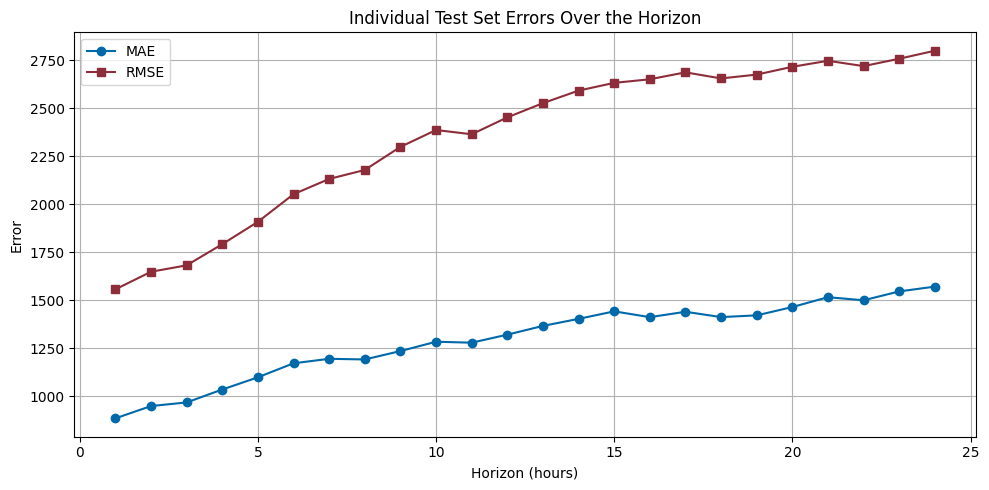

In [45]:
plot_error_over_horizon(y_lagged_test, xgb_pred_lagged, horizon=horizon)

In [46]:
# Lagged XGBoost Last Only Regressor Chain
last_only_lagged_chain = LastOnlyRegressorChain(
    xgb.XGBRegressor(
        n_estimators=1000,
        random_state=1312,
    )
)
last_only_lagged_chain.fit(X_lagged_train.to_numpy(), y_lagged_train.to_numpy())
xgb_pred_last_only_lagged = last_only_lagged_chain.predict(X_lagged_test.to_numpy())
r2_score_xgb_last_only_lagged = last_only_lagged_chain.score(X_lagged_test.to_numpy(), y_lagged_test)

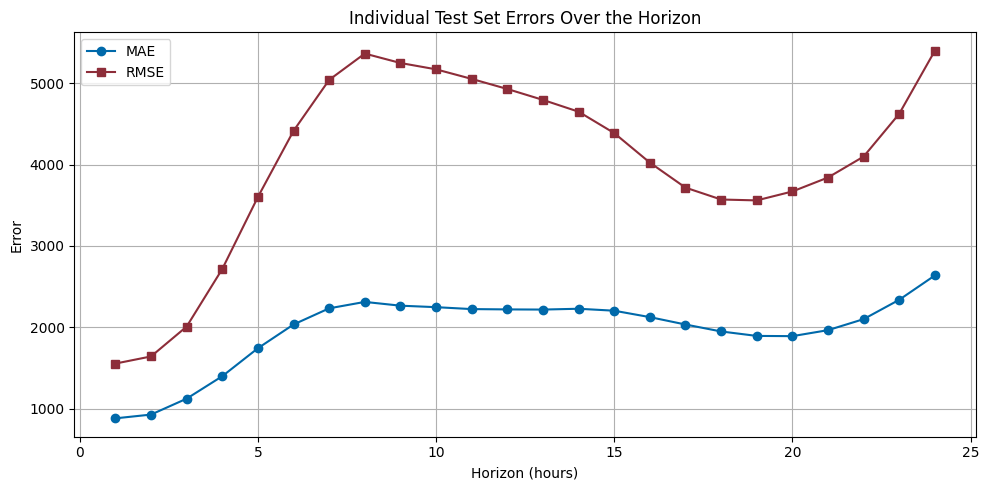

In [47]:
xgb_lagged_chain_eval = ModelEvaluation(
    model_name='Lagged Chained Last Only',
    model=last_only_lagged_chain,
    horizon=horizon,
    y_pred=pd.DataFrame(xgb_pred_last_only_lagged, index=y_lagged_test.index),
    R2_score=r2_score_xgb_last_only_lagged,
    RMSE=[mean_squared_error(y_lagged_test.iloc[:, i], xgb_pred_last_only_lagged[:, i], squared=False) for i in range(horizon)],
    MAE=[mean_absolute_error(y_lagged_test.iloc[:, i], xgb_pred_last_only_lagged[:, i]) for i in range(horizon)]
)
evaluations.append(xgb_lagged_chain_eval)
plot_error_over_horizon(y_lagged_test, xgb_pred_last_only_lagged, horizon=horizon)

# 5. Evaluation
Now we can compare all the models.

Lasso: R2: 0.7847323675240458
RMSE: 4429.891845241874, MAE: 3389.2582629639046
XGBoost: R2: 0.9712215521555476
RMSE: 1619.710655562959, MAE: 949.0809680836198
XGBoost Naive: R2: 0.9740071216935442
RMSE: 1539.3271972932725, MAE: 910.1493204327858
Parallel: R2: 0.9359478583782902
Chained: R2: 0.7448082179423903
Chained Last Only: R2: 0.7845825072389685
Lagged parallel: R2: 0.9375138151805992
Lagged Chained Last Only: R2: 0.8078509120204546


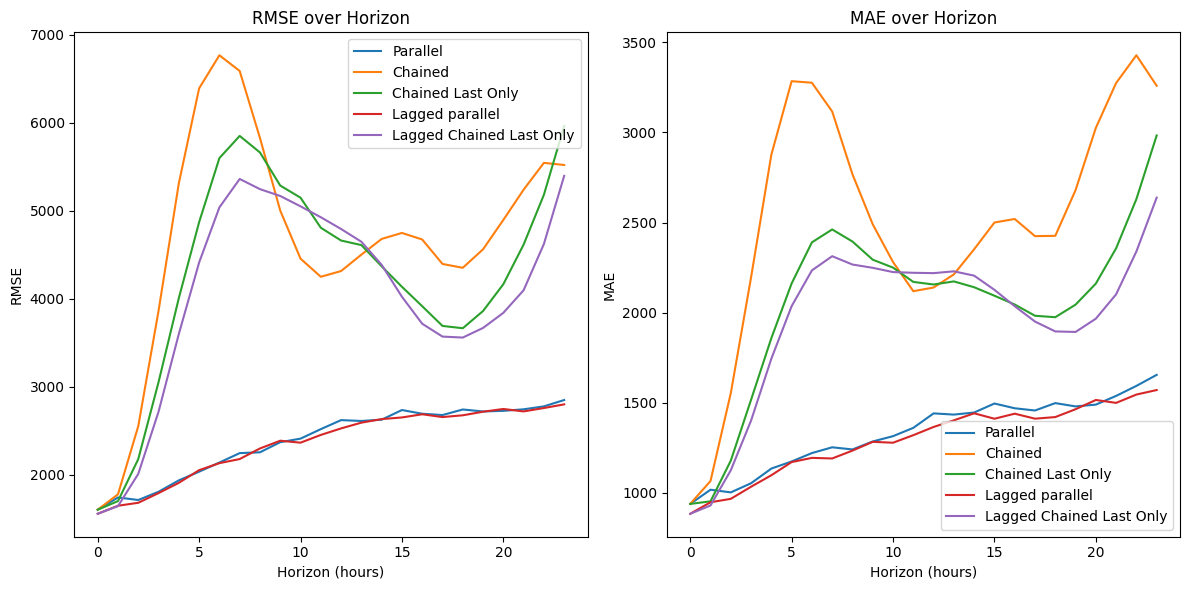

In [48]:
# Compare all evaluations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
for eval in evaluations:
    print(f"{eval.model_name}: R2: {eval.R2_score}")
    if eval.horizon == 1:
        print(f"RMSE: {eval.RMSE}, MAE: {eval.MAE}")
    else:
        ax1.plot(eval.RMSE, label=eval.model_name)
        ax2.plot(eval.MAE, label=eval.model_name)

ax1.set_title('RMSE over Horizon')
ax1.set_xlabel('Horizon (hours)')
ax1.set_ylabel('RMSE')
ax1.legend()
ax2.set_title('MAE over Horizon')
ax2.set_xlabel('Horizon (hours)')
ax2.set_ylabel('MAE')
ax2.legend()
plt.tight_layout()
plt.show()